# Trial on the Nigeria data from "Satellite Imagery as Controls in Causal Social Science"

As a quick test, I tested our debiasing methods using the aid treatment data from the paper "Satellite Imagery as Controls in Causal Social Science: Applications and Scope in Data-Scarce Settings." In this first iteration, I didn't consider any confounders, meaning that the predictions are likely to be uninformative of the true treatment effect. However, this is of less importance to us, as our goal is merely to recapture the same signal using predicted labels as we would get with the true labels.

In this notebook, I randomly split the full DHS dataset into "upstream" and "downstream" sets. I then fit a model to predict IWI using the upstream set. Then, using only the part of the downstream dataset with a treatment status (i.e., the locations from the "Nigeria 2018 Standard DHS"), I obtain the **observed treatment effect** by simply taking the mean difference between the IWI labels of the treated and control groups. I then do the same using the model-predicted values to obtain the **predicted treatment effect**. As expected, the prediction is attenuated. Finally, I run the different debiasing methods on these predictions to obtain the **LCC predicted treatment effect** and the **Tweedie's predicted treatment effect**. Unfortunately, it seems like the debiasing methods did *not* yield the expected improvements, indicating that we have more understanding to do.

In [1]:
import os
import configparser
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from utils import RegressionModel, train_model, plot_results
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']
RANDOM_STATE = 43
N_COMPONENTS = 232

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Add treatement status "Wobs" from Connor's file to the full DHS dataset

In [2]:
embeddings = np.load(os.path.join(DATA_DIR, 'ssl4eo_resnet50.npy'))
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))

# Load treatment data from CJ's huggingface repo
t_df = pd.read_csv('https://huggingface.co/datasets/cjerzak/ImageConfounding/resolve/main/YandW_mat.csv')

# Set the treatment data to the correct survey
df.loc[df['survey'] == 'Nigeria 2018 Standard DHS', 'Wobs'] = t_df['Wobs'].values.astype(int)

df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,Wobs
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459,NaN
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589,NaN
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211,NaN
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697,NaN
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944,NaN
...,...,...,...,...,...,...,...,...,...,...,...
68614,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567,NaN
68615,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878,NaN
68616,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326,NaN
68617,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344,NaN


Split full dataset into upstream/downstream data

In [3]:
assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'

X = embeddings

# Cheat by doing rescaling and PCA on the whole set
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=N_COMPONENTS)
X = pca.fit_transform(X)

Y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
Y = Y.clip(0, 1)

X = torch.tensor(X, dtype=torch.float).to(device)
Y = torch.tensor(Y, dtype=torch.float).to(device)

X_up_stream, X_dwn_stream, y_up_stream, y_dwn_stream, df_up_stream, df_dwn_stream = train_test_split(X, Y, df, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val, df_train, df_val = train_test_split(X_up_stream, y_up_stream, df_up_stream, test_size=0.2, random_state=RANDOM_STATE)

 13%|█▎        | 6300/50000 [00:13<01:33, 465.65it/s]


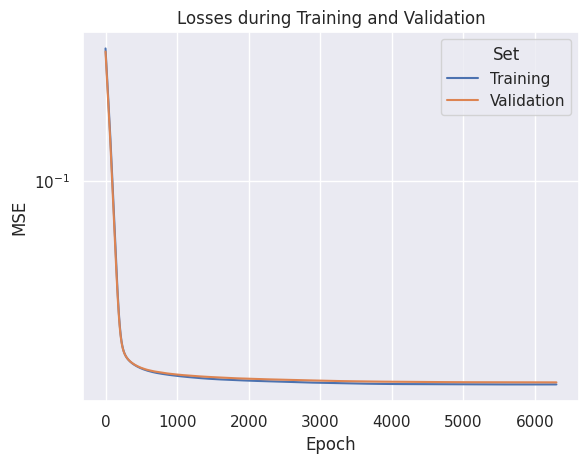

In [4]:
# Example of a loss function that only tracks one metric (MSE)
def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=1)

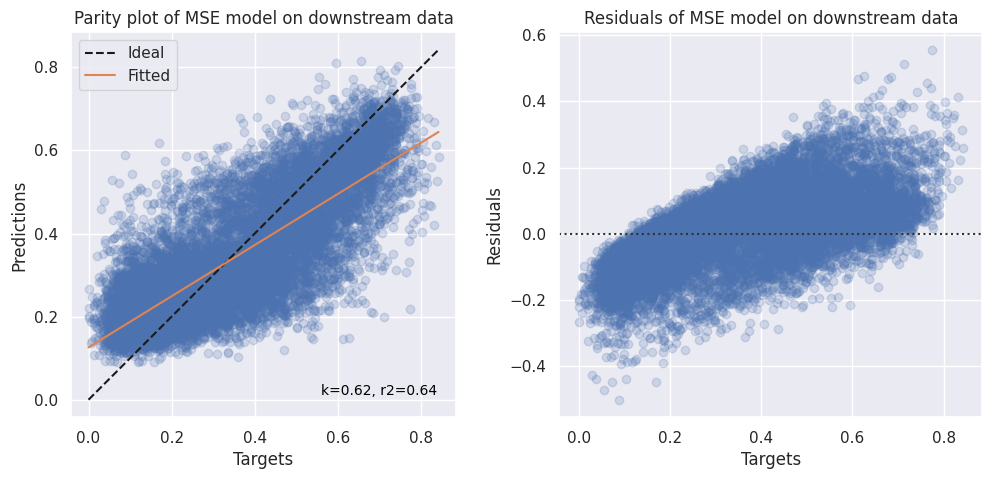

In [5]:
with torch.no_grad():
    y_pred = mse_model(X_dwn_stream)
    
plot_results(y_dwn_stream, y_pred, 'MSE model on downstream data')

Get the "trial set" by extracting the part of the downstream data that has a treatment status, i.e., the ones from the 2018 Nigeria survey

In [6]:
trial_ixs = ~df_dwn_stream['Wobs'].isna()
trial_df = df_dwn_stream[trial_ixs]
trial_df['iwi_hat'] = 100 * y_pred.cpu().numpy()[trial_ixs]

trial_df

/local/tmp.4462743/ipykernel_2150536/2680629834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_df['iwi_hat'] = 100 * y_pred.cpu().numpy()[trial_ixs]


,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,Wobs,iwi_hat
45237,NG.North West.7B.702,5.569023,13.471167,True,NG.North West,Nigeria,Nigeria 2018 Standard DHS,12,2018,10.195151,0.0,16.469793
47061,NG.South South.7B.1136,7.277163,4.608204,False,NG.South South,Nigeria,Nigeria 2018 Standard DHS,9,2018,24.790692,0.0,28.896935
46948,NG.South South.7B.1023,9.183928,6.540892,True,NG.South South,Nigeria,Nigeria 2018 Standard DHS,10,2018,34.872891,0.0,22.456717
47800,NG.South West.7B.1352,4.487157,7.763419,True,NG.South West,Nigeria,Nigeria 2018 Standard DHS,8,2018,63.580375,1.0,37.456684
47059,NG.South South.7B.1134,7.119563,4.797731,False,NG.South South,Nigeria,Nigeria 2018 Standard DHS,9,2018,63.409559,1.0,43.433323
...,...,...,...,...,...,...,...,...,...,...,...,...
44338,NG.North Central.7B.51,7.584135,9.033980,False,NG.North Central,Nigeria,Nigeria 2018 Standard DHS,12,2018,65.679818,0.0,42.433125
45041,NG.North West.7B.501,9.371704,11.672697,True,NG.North West,Nigeria,Nigeria 2018 Standard DHS,8,2018,36.669507,0.0,35.002048
45066,NG.North West.7B.526,7.443144,9.909820,False,NG.North West,Nigeria,Nigeria 2018 Standard DHS,10,2018,19.538537,0.0,24.271296
47755,NG.South West.7B.1306,5.779381,7.373035,True,NG.South West,Nigeria,Nigeria 2018 Standard DHS,9,2018,36.017416,0.0,27.294630


Looking at only the points from the "trial set", the performance differs from considering the whole "downstream set"

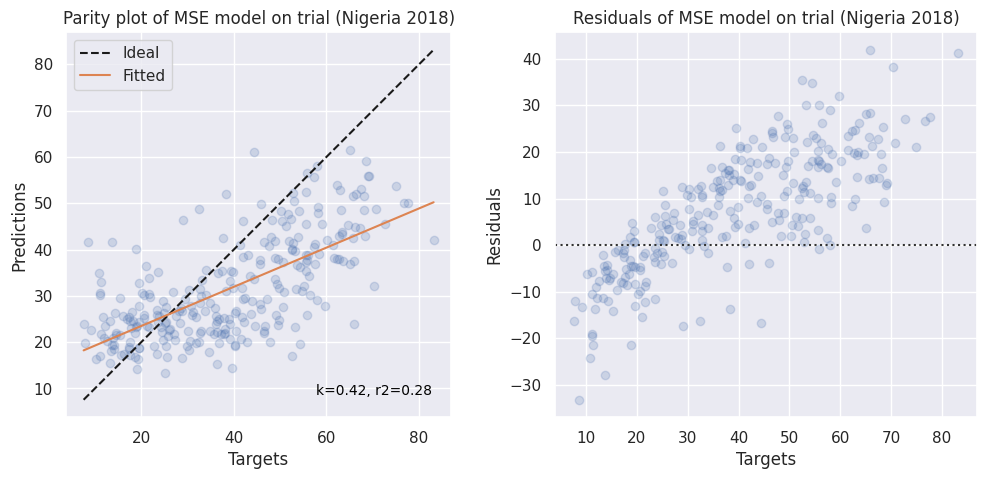

In [7]:
plot_results(torch.tensor(trial_df['iwi'].values).cuda(), torch.tensor(trial_df['iwi_hat'].values).cuda(), 'MSE model on trial (Nigeria 2018)')

Get the observed and estimated treatment effect by looking at the trial set

In [8]:
# Calculate the treatment effect
treatment_effect = trial_df[trial_df['Wobs'] == 1]['iwi'].mean() - trial_df[trial_df['Wobs'] == 0]['iwi'].mean()
treatment_effect_hat = trial_df[trial_df['Wobs'] == 1]['iwi_hat'].mean() - trial_df[trial_df['Wobs'] == 0]['iwi_hat'].mean()
print(f'Treatment effect (observed): {treatment_effect:.4f}')
print(f'Treatment effect (predicted): {treatment_effect_hat:.4f}')

Treatment effect (observed): 19.5228
Treatment effect (predicted): 14.3378


As expected, the predicted treatment effect is attenuated towards 0.

## Debiasing

### Linear Correlation Correction

Fit LCC debiasing using validation data. Make predictions on the trial set

In [9]:
km_regressor = LinearRegression()
km_regressor.fit(trial_df['iwi'].values.reshape(-1, 1), trial_df['iwi_hat'].values)

k = km_regressor.coef_[0]
m = km_regressor.intercept_
print(f'Estimated slope (k): {k:.4f}')
print(f'Estimated intercept (m): {m:.4f}')

# Calculate the treatment effect
treatment_effect_km_hat = treatment_effect_hat / k
print(f'Treatment effect (LCC): {treatment_effect_km_hat:.4f}')

Estimated slope (k): 0.4232
Estimated intercept (m): 15.0258
Treatment effect (LCC): 33.8788


### Tweedie's method

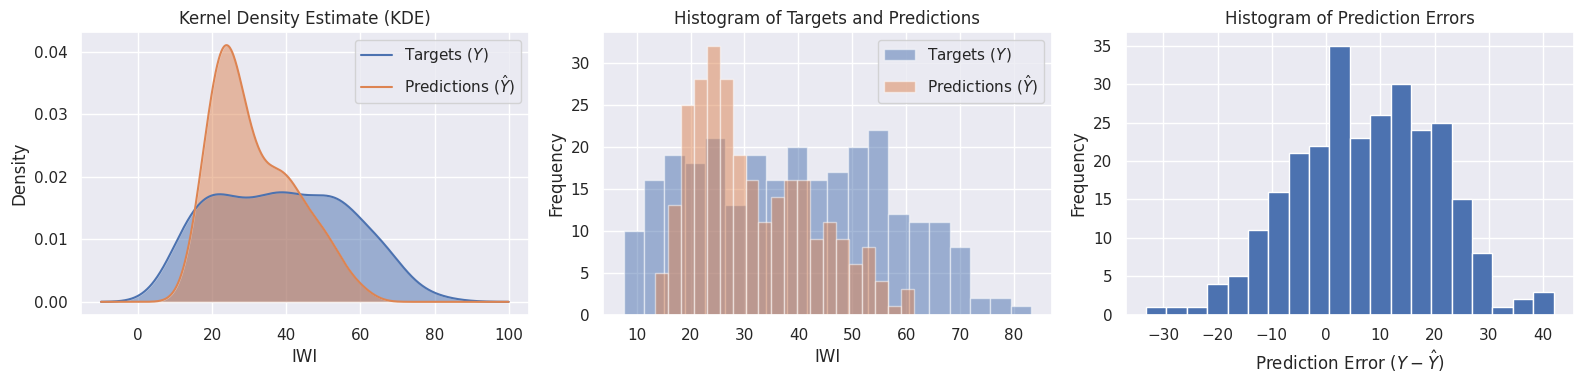

In [12]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Create KDE for marginal density p_Y(y)
target_kde = gaussian_kde(trial_df['iwi'])
pred_kde = gaussian_kde(trial_df['iwi_hat'])

# Create a range of x values to evaluate the KDE over
y_values = np.linspace(-10, 100, 1000)

# Evaluate the KDE over these x values
target_kde_values = target_kde(y_values)
pred_kde_values = pred_kde(y_values)

plt.figure(figsize=(16, 4))

# Plot the KDE
plt.subplot(1, 3, 1)
plt.plot(y_values, target_kde_values, label="Targets ($Y$)")
plt.fill_between(y_values, target_kde_values, alpha=0.5)
plt.plot(y_values, pred_kde_values, label="Predictions $(\hat{Y})$")
plt.fill_between(y_values, pred_kde_values, alpha=0.5)
plt.title("Kernel Density Estimate (KDE)")
plt.xlabel("IWI")
plt.ylabel("Density")
plt.legend()

# Plot histogram of targets and predictions
plt.subplot(1, 3, 2)
plt.hist(trial_df['iwi'], bins=20, alpha=0.5, label="Targets ($Y$)")
plt.hist(trial_df['iwi_hat'], bins=20, alpha=0.5, label="Predictions $(\hat{Y})$")
plt.title('Histogram of Targets and Predictions')
plt.xlabel('IWI')
plt.ylabel('Frequency')
plt.legend()

# Plot histogram of prediction errors
plt.subplot(1, 3, 3)
plt.hist(trial_df['iwi'] - trial_df['iwi_hat'], bins=20)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error $(Y - \hat{Y})$')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

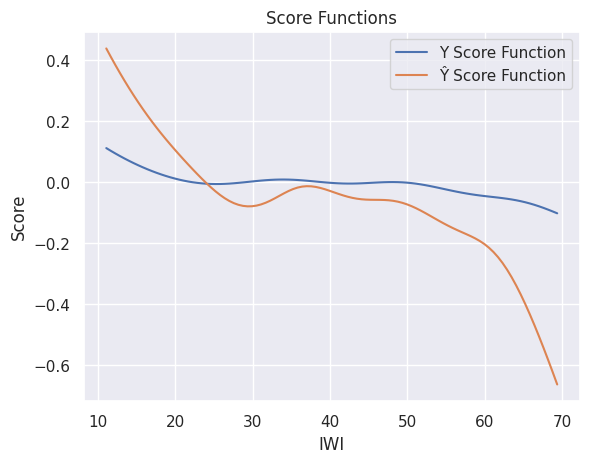

In [14]:
# Define evaluation points (avoid extreme values)
lower = np.percentile(trial_df['iwi'], 2.5)
upper = np.percentile(trial_df['iwi'], 97.5)
y_vals = np.linspace(lower, upper, 100)

# Finite difference step for derivative
delta = 1e-5

scores = []
pred_scores = []

def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

for y in y_vals:
    
    # Derivative of log density for targets
    scores.append(score_function(y, target_kde))

    # Derivative of log density for predictions
    pred_scores.append(score_function(y, pred_kde))

# Plot score function
plt.plot(y_vals, scores, label="Y Score Function")
plt.plot(y_vals, pred_scores, label="Ŷ Score Function")
plt.title("Score Functions")
plt.xlabel("IWI")
plt.ylabel("Score")
plt.legend()
plt.show()

Get the estimate of $\sigma$ from the validation set.

In [ ]:
with torch.no_grad():
    y_pred = mse_model(X_val)
    res_val = 100*(y_val - y_pred)

res_std = res_val.cpu().numpy().std()
print('Var(Y - Y-hat):', res_std)

Var(Y - Y-hat): 11.607438


Calculate score function values using the trial distribution

In [ ]:
prediction_scores = np.array([score_function(y, pred_kde) for y in trial_df['iwi_hat']])

In [ ]:
treatment_effect_tweedies_hat = treatment_effect_hat - res_std * (prediction_scores[trial_df['Wobs'] == 1].mean() - prediction_scores[trial_df['Wobs'] == 0].mean())

print(f'Treatment effect (observed): {treatment_effect:.4f}')
print(f'Treatment effect (predicted): {treatment_effect_hat:.4f}')
print(f'Treatment effect (LCC): {treatment_effect_km_hat:.4f}')
print(f'Treatment effect (Tweedies): {treatment_effect_tweedies_hat:.4f}')

Treatment effect (observed): 17.7639
Treatment effect (predicted): 13.6617
Treatment effect (LCC): 30.5873
Treatment effect (Tweedies): 14.4431


## Conclusion

The effect of the debiasing is small with Tweedie's and too large using LCC. However, since we only have one sample, it is hard to draw any conclusions about debiasing.

**TODO:** Run analysis with bootstrap

In [27]:
pd.options.mode.chained_assignment = None

def run_bootstrap(X, y, df, seed):

    # Split the data into training and validation sets
    X_up_stream, X_dwn_stream, y_up_stream, y_dwn_stream, df_up_stream, df_dwn_stream = train_test_split(X, Y, df, test_size=0.2, random_state=seed)
    X_train, X_val, y_train, y_val, df_train, df_val = train_test_split(X_up_stream, y_up_stream, df_up_stream, test_size=0.2, random_state=seed)

    # Train the model
    mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=0)

    # Evaluate the model on the downstream data
    with torch.no_grad():
        y_pred = mse_model(X_dwn_stream)

    # Get the trial data
    trial_ixs = ~df_dwn_stream['Wobs'].isna()
    trial_df = df_dwn_stream[trial_ixs]
    trial_df['iwi_hat'] = 100 * y_pred.cpu().numpy()[trial_ixs]

    # Calculate the treatment effect
    treatment_effect = trial_df[trial_df['Wobs'] == 1]['iwi'].mean() - trial_df[trial_df['Wobs'] == 0]['iwi'].mean()
    treatment_effect_hat = trial_df[trial_df['Wobs'] == 1]['iwi_hat'].mean() - trial_df[trial_df['Wobs'] == 0]['iwi_hat'].mean()

    # Do the LCC debiasing
    km_regressor = LinearRegression()
    km_regressor.fit(trial_df['iwi'].values.reshape(-1, 1), trial_df['iwi_hat'].values)
    k = km_regressor.coef_[0]
    treatment_effect_km_hat = treatment_effect_hat / k

    # Do the Tweedies debiasing
    pred_kde = gaussian_kde(trial_df['iwi_hat'])

    with torch.no_grad():
        y_pred = mse_model(X_val)
        res_val = 100*(y_val - y_pred)

    res_std = res_val.cpu().numpy().std()
    prediction_scores = np.array([score_function(y, pred_kde) for y in trial_df['iwi_hat']])

    treatment_effect_tweedies_hat = treatment_effect_hat - res_std * (prediction_scores[trial_df['Wobs'] == 1].mean() - prediction_scores[trial_df['Wobs'] == 0].mean())

    # Do Tweedie's debiasing with res_std from the trial set
    trial_res_std = (trial_df['iwi_hat'].values - trial_df['iwi'].values).std()
    treatment_effect_tweedies_trial_hat = treatment_effect_hat - trial_res_std * (prediction_scores[trial_df['Wobs'] == 1].mean() - prediction_scores[trial_df['Wobs'] == 0].mean())

    res = {
        'Treatment effect (observed)': treatment_effect,
        'Treatment effect (predicted)': treatment_effect_hat,
        'Treatment effect (LCC)': treatment_effect_km_hat,
        'Treatment effect (Tweedies)': treatment_effect_tweedies_hat,
        'Treatment effect (Tweedies with real sigma)': treatment_effect_tweedies_trial_hat,
    }

    return res

# Run the bootstrap
n_iterations = 20

results = []
for i in tqdm(range(n_iterations)):
    res = run_bootstrap(X, Y, df, i)
    results.append(res)

results_df = pd.DataFrame(results)

results_df

100%|██████████| 20/20 [03:54<00:00, 11.74s/it]


,Treatment effect (observed),Treatment effect (predicted),Treatment effect (LCC),Treatment effect (Tweedies),Treatment effect (Tweedies with real sigma)
0,14.751435,11.709974,28.154708,12.467603,12.542465
1,19.248212,12.286102,30.264470,13.167387,13.251806
2,18.225776,13.331285,30.205281,14.077776,14.115981
3,17.795487,14.164509,32.563917,14.925687,14.995924
4,19.113723,14.479633,32.983474,15.272808,15.372539
5,18.664291,13.652271,32.223567,14.584743,14.656603
6,15.796496,13.575489,29.622340,14.300056,14.334420
7,16.147336,11.332846,27.041115,12.005998,12.044082
8,13.011099,12.814793,30.648334,13.587968,13.644780
9,16.319744,13.763756,29.719214,14.417017,14.424084


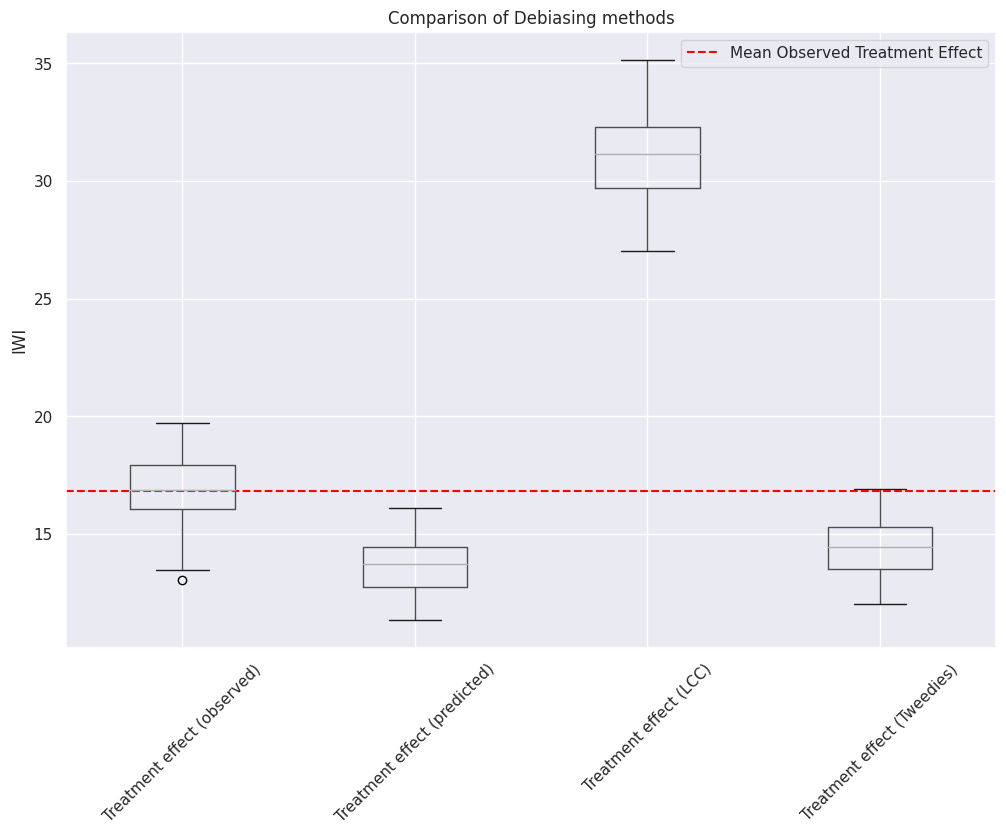

In [26]:
plt.figure(figsize=(12, 8))

# Plot boxplots for the treatment effects
results_df.boxplot()
plt.axhline(y=results_df['Treatment effect (observed)'].mean(), color='red', linestyle='--', label='Mean Observed Treatment Effect')

# Add labels and title
plt.title('Comparison of Debiasing methods')
plt.ylabel('IWI')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.show()